In [25]:
# importing the packages
import sys # check if the correct .venv in activated.
print(sys.executable)
import pandas as pd
import json
import requests

/opt/anaconda3/bin/python


In [26]:
# Loading the data into the dataframes
dt_tag = pd.read_csv('data/tag.csv')
dt_rating = pd.read_csv('data/rating.csv')
dt_movie = pd.read_csv('data/movie.csv')
dt_link = pd.read_csv('data/link.csv')  
dt_genome_scores = pd.read_csv('data/genome_scores.csv')
dt_genome_tags = pd.read_csv('data/genome_tags.csv')  

In [27]:
import numpy as np

# Function to count empty strings and NaNs
def count_missing_values(df, name):
    empty_strings = (df == '').sum()
    missing_values = df.isnull().sum()
    total_missing = empty_strings + missing_values
    print(f'{name} missing or empty values per column:')
    print(total_missing)
    # Replace empty strings with NaN and drop rows with any NaN
    df.replace('', np.nan, inplace=True)
    df.dropna(inplace=True)
    print(f'{name} shape after dropping missing values: {df.shape}\n')

# Apply the function to each dataframe
count_missing_values(dt_tag, 'dt_tag')
count_missing_values(dt_rating, 'dt_rating')
count_missing_values(dt_movie, 'dt_movie')
count_missing_values(dt_link, 'dt_link')
count_missing_values(dt_genome_scores, 'dt_genome_scores')
count_missing_values(dt_genome_tags, 'dt_genome_tags')

dt_tag missing or empty values per column:
userId        0
movieId       0
tag          16
timestamp     0
dtype: int64
dt_tag shape after dropping missing values: (465548, 4)

dt_rating missing or empty values per column:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
dt_rating shape after dropping missing values: (20000263, 4)

dt_movie missing or empty values per column:
movieId    0
title      0
genres     0
dtype: int64
dt_movie shape after dropping missing values: (27278, 3)

dt_link missing or empty values per column:
movieId      0
imdbId       0
tmdbId     252
dtype: int64
dt_link shape after dropping missing values: (27026, 3)

dt_genome_scores missing or empty values per column:
movieId      0
tagId        0
relevance    0
dtype: int64
dt_genome_scores shape after dropping missing values: (11709768, 3)

dt_genome_tags missing or empty values per column:
tagId    0
tag      0
dtype: int64
dt_genome_tags shape after dropping missing values: (1128, 2)


#### **3. TMDb API Setup**

- **API Key**: Go to [TMDb](https://www.themoviedb.org/) to sign up for an account and generate an API key.
- **Base URL**: The base URL for the API is `https://api.themoviedb.org/3`.

In [28]:
api_key = "Removed, csv tables already made"


In [29]:
# Helper function to validate the API key should not be valid for you since all the tables already are generated with the API-key and it takes 3 hours so no need to do it again
def is_valid_api_key(api_key):
    test_url = f'https://api.themoviedb.org/3/movie/550?api_key={api_key}'  # Example using a known movie ID
    response = requests.get(test_url)
    return response.status_code == 200  # If 200, the key is valid

In [30]:
if not is_valid_api_key(api_key):
    print("Invalid TMDb API key, csv files already generated with API key. Skipping API-related operations.")

Invalid TMDb API key, csv files already generated with API key. Skipping API-related operations.


## Check Movie Existence in TMDb API

This notebook checks if each movie in our `dt_movie` dataset exists in the TMDb API. We have 27,278 movies, and some already have a `tmdbId` in the `dt_link` dataset. We'll:

### Steps
1. Load the data.
2. Label movies that does not exist in the tmdb API.
3. Save the results.

### Skipping this step since the table already is generated and it takes 2 hours to run

In [31]:
import time
import requests  # Ensure this is imported for the API calls
import pandas as pd  # Assuming pandas is needed

# Your TMDb API key
api_key = "your_api_key_here"

# Helper function to validate the API key
def is_valid_api_key(api_key):
    test_url = f'https://api.themoviedb.org/3/movie/550?api_key={api_key}'  # Example using a known movie ID
    response = requests.get(test_url)
    return response.status_code == 200  # If 200, the key is valid

# Validate API key
if is_valid_api_key(api_key):
    print("Valid API key. Proceeding with TMDb checks...")
    
    # Assume dt_movie and dt_link are already loaded DataFrames
    # Step 1: Merge dt_movie with dt_link to bring in `tmdbId`
    merged_data = pd.merge(dt_movie, dt_link[['movieId', 'tmdbId']], on='movieId', how='left')

    # Step 2: Separate movies with and without tmdbId
    with_tmdb_id = merged_data[merged_data['tmdbId'].notna()]
    without_tmdb_id = merged_data[merged_data['tmdbId'].isna()]

    # Initialize results DataFrame
    results = pd.DataFrame(columns=['movieId', 'title', 'exists_in_tmdb'])

    # Helper function to check if a movie exists in TMDb by its TMDb ID
    def check_movie_by_id(tmdb_id):
        url = f'https://api.themoviedb.org/3/movie/{int(tmdb_id)}?api_key={api_key}'
        response = requests.get(url)
        return response.status_code == 200  # Status 200 means movie found

    # Helper function to check if a movie exists in TMDb by its title
    def check_movie_by_title(title):
        url = f'https://api.themoviedb.org/3/search/movie?api_key={api_key}&query={title}'
        response = requests.get(url)
        data = response.json()
        return data['total_results'] > 0 if 'total_results' in data else False

    # Step 3: Check movies with `tmdbId` directly
    print("Checking movies with known tmdbId...")
    for i, row in with_tmdb_id.iterrows():
        exists = check_movie_by_id(row['tmdbId'])
        print(i)
        # Using pd.concat to add new row to results
        results = pd.concat([results, pd.DataFrame([{'movieId': row['movieId'], 'title': row['title'], 'exists_in_tmdb': exists}])], ignore_index=True)
        time.sleep(0.1)  # Avoid hitting rate limit

    # Step 4: Check movies without `tmdbId` by title
    print("Checking movies by title for those without tmdbId...")
    for i, row in without_tmdb_id.iterrows():
        exists = check_movie_by_title(row['title'])
        print(i)
        # Using pd.concat to add new row to results
        results = pd.concat([results, pd.DataFrame([{'movieId': row['movieId'], 'title': row['title'], 'exists_in_tmdb': exists}])], ignore_index=True)
        time.sleep(0.1)  # Avoid hitting rate limit

    # Step 5: Save results to CSV for further analysis
    results.to_csv('data/movie_existence_results.csv', index=False)

    # Summary statistics
    print(f"Total movies checked: {len(results)}")
    print(f"Movies found in TMDb: {results['exists_in_tmdb'].sum()}")
    print(f"Movies not found in TMDb: {len(results) - results['exists_in_tmdb'].sum()}")

else:
    print("Invalid TMDb API key, csv files already generated with API key. Skipping TMDb-related operations.")


Invalid TMDb API key, csv files already generated with API key. Skipping TMDb-related operations.


## Remove Movies that Exist in Kaggle Dataset but Not in TMDb API (534 Movies)

1. **Load the `movie_existence_results.csv`**: This file contains each movie's `movieId` along with a boolean column `exists_in_tmdb`. We'll use this information to identify the movies not found in TMDb.
2. **Filter Movies Across All Tables**: For each relevant table (`dt_tag`, `dt_rating`, `dt_movie`, `dt_link`, and `dt_genome_scores`), we'll exclude rows associated with these missing `movieId`s.
3. **Save or Display Results**: We’ll save each cleaned DataFrame to a new CSV file or display their shapes to verify the filtering process.



In [32]:
# Load the movie existence results to get the list of movies not found in TMDb
movie_existence_results = pd.read_csv('data/movie_existence_results.csv')
not_found_movies = movie_existence_results[movie_existence_results['exists_in_tmdb'] == False]['movieId'].tolist()

# Filter each DataFrame to exclude movies not found in TMDb
dt_tag_cleaned = dt_tag[~dt_tag['movieId'].isin(not_found_movies)]
dt_rating_cleaned = dt_rating[~dt_rating['movieId'].isin(not_found_movies)]
dt_movie_cleaned = dt_movie[~dt_movie['movieId'].isin(not_found_movies)]
dt_link_cleaned = dt_link[~dt_link['movieId'].isin(not_found_movies)]
dt_genome_scores_cleaned = dt_genome_scores[~dt_genome_scores['movieId'].isin(not_found_movies)]
dt_genome_tags_cleaned = dt_genome_tags.copy()  # No need to filter genome_tags

# Display the shapes of the cleaned DataFrames to confirm the filtering
print("dt_tag_cleaned shape:", dt_tag_cleaned.shape)
print("dt_rating_cleaned shape:", dt_rating_cleaned.shape)
print("dt_movie_cleaned shape:", dt_movie_cleaned.shape)
print("dt_link_cleaned shape:", dt_link_cleaned.shape)
print("dt_genome_scores_cleaned shape:", dt_genome_scores_cleaned.shape)
print("dt_genome_tags_cleaned shape:", dt_genome_tags_cleaned.shape)

# Optionally, save the cleaned DataFrames back to CSV for future use
dt_tag_cleaned.to_csv('data/dt_tag_cleaned.csv', index=False)
dt_rating_cleaned.to_csv('data/dt_rating_cleaned.csv', index=False)
dt_movie_cleaned.to_csv('data/dt_movie_cleaned.csv', index=False)
dt_link_cleaned.to_csv('data/dt_link_cleaned.csv', index=False)
dt_genome_scores_cleaned.to_csv('data/dt_genome_scores_cleaned.csv', index=False)
dt_genome_tags_cleaned.to_csv('data/dt_genome_tags_cleaned.csv', index=False)


dt_tag_cleaned shape: (462004, 4)
dt_rating_cleaned shape: (19958032, 4)
dt_movie_cleaned shape: (26744, 3)
dt_link_cleaned shape: (26735, 3)
dt_genome_scores_cleaned shape: (11620656, 3)
dt_genome_tags_cleaned shape: (1128, 2)


#### **4. Fetch Popular Movies**

Let’s start by fetching a list of popular movies from the TMDb API. Each movie entry includes basic details like title, release date, and rating.

In [33]:
# Validate API key
if is_valid_api_key(api_key):
    print("Valid API key. Fetching sample movie data...")

    # Choose a sample movie_id; here we use 550, which corresponds to the movie "Fight Club"
    sample_movie_id = 550

    # Construct the API request URL
    url = f'https://api.themoviedb.org/3/movie/{sample_movie_id}?api_key={api_key}'

    # Send the request to TMDb API
    response = requests.get(url)

    # Check if the response is successful
    if response.status_code == 200:
        # Parse the JSON response
        movie_data = response.json()
        
        # Display all available fields (features/columns) in the movie data
        print(f"Available fields in TMDb API for the sample movie (movie_id = {sample_movie_id}):")
        for key in movie_data.keys():
            print(key)
    else:
        print(f"Failed to fetch data. Status code: {response.status_code}, Message: {response.text}")

else:
    print("Invalid TMDb API key, csv files already generated with API key. Skipping API call for sample movie data.")

Invalid TMDb API key, csv files already generated with API key. Skipping API call for sample movie data.


#### **5. Fetch Detailed Movie Information**

Once we have a list of popular movies, we can fetch detailed information for each movie by using its unique `movie_id`.

In [34]:
import pandas as pd
import requests
import time

if is_valid_api_key(api_key):
    print("Valid API key. Proceeding with feature extraction...")

    dt_movie = pd.read_csv('data/dt_movie_cleaned.csv')   # Contains movieId, title, genres
    dt_link = pd.read_csv('data/dt_link_cleaned.csv')     # Contains movieId, imdbId, tmdbId
    dt_genome_scores = pd.read_csv('data/dt_genome_scores_cleaned.csv')  # Contains movieId, tagId, relevance
    dt_genome_tag = pd.read_csv('data/dt_genome_tags_cleaned.csv')       # Contains tagId, tag
    dt_rating = pd.read_csv('data/dt_rating_cleaned.csv')  # Contains userId, movieId, rating, timestamp

    # Merge dt_movie with dt_link to include `tmdbId`
    merged_data = pd.merge(dt_movie, dt_link[['movieId', 'tmdbId']], on='movieId', how='left')

    # Filter for movies that have a valid `tmdbId`
    movies_with_tmdbId = merged_data[merged_data['tmdbId'].notna()]

    # Prepare an empty list to collect additional features
    additional_features = []

    # Helper function to fetch movie details from TMDb
    def fetch_tmdb_movie_data(tmdb_id):
        url = f'https://api.themoviedb.org/3/movie/{int(tmdb_id)}?api_key={api_key}'
        response = requests.get(url)
        if response.status_code == 200:
            return response.json()
        return None

    # Loop over movies with `tmdbId` and fetch additional features from TMDb
    for _, row in movies_with_tmdbId.iterrows():
        tmdb_id = int(row['tmdbId'])
        movie_data = fetch_tmdb_movie_data(tmdb_id)
        
        if movie_data:
            # Append relevant fields to the list
            print(f"Fetching data for movieId: {row['movieId']}, tmdbId: {tmdb_id}")
            additional_features.append({
                'movieId': row['movieId'],
                'popularity': movie_data.get('popularity'),
                'vote_average': movie_data.get('vote_average'),
                'vote_count': movie_data.get('vote_count'),
                'runtime': movie_data.get('runtime'),
                'release_date': movie_data.get('release_date'),
                'production_countries': [country['name'] for country in movie_data.get('production_countries', [])],
                'revenue': movie_data.get('revenue'),
                'budget': movie_data.get('budget'),
                'spoken_languages': [language['name'] for language in movie_data.get('spoken_languages', [])],
                'adult': movie_data.get('adult')
            })
        else:
            # Append None values if the movie data is not found
            print(f"Data not found for movieId: {row['movieId']}, tmdbId: {tmdb_id}")
            additional_features.append({
                'movieId': row['movieId'],
                'popularity': None,
                'vote_average': None,
                'vote_count': None,
                'runtime': None,
                'release_date': None,
                'production_countries': None,
                'revenue': None,
                'budget': None,
                'spoken_languages': None,
                'adult': None
            })
        
        time.sleep(0.1)  # To avoid hitting TMDb rate limits

    # Convert additional features to a DataFrame
    additional_features_df = pd.DataFrame(additional_features)

    # Merge additional features with the movie data
    final_movie_data = pd.merge(additional_features_df, dt_movie, on='movieId', how='left')

    # **Select only the highest relevance tag per movie**

    #### Steps to get the top 5 most relevant tags and turn them into one string #####
    #sorted_genome_scores = dt_genome_scores.sort_values(by=['movieId', 'relevance'], ascending=[True, False])
    #top_5_tags_per_movie = sorted_genome_scores.groupby('movieId').head(5)
    #tags_with_names = pd.merge(top_5_tags_per_movie, dt_genome_tag, on='tagId', how='inner')
    #tags_summary = tags_with_names.groupby('movieId')['tag'].apply(lambda x: ' | '.join(x)).reset_index()
    #final_movie_data = pd.merge(final_movie_data, tags_summary[['movieId', 'tag']], on='movieId', how='left')

    # Step 1: Get the highest relevance for each movieId
    highest_relevance_tags = dt_genome_scores.loc[dt_genome_scores.groupby('movieId')['relevance'].idxmax()]

    # Step 2: Merge with `dt_genome_tag` to get tag names for the highest relevance tags
    tags_data = pd.merge(highest_relevance_tags, dt_genome_tag, on='tagId', how='inner')

    # Merge the tags data with the main movie data
    final_movie_data = pd.merge(final_movie_data, tags_data[['movieId', 'tag']], on='movieId', how='left')

    # Save the final dataset with TMDb features and tags included
    final_movie_data.to_csv('data/movies_with_tmdb_features_and_tags.csv', index=False)

    # Display a sample of the final dataset
    print(final_movie_data.head())
else:
    print("Invalid TMDb API key, csv file already generated with API key.")


Invalid TMDb API key, csv file already generated with API key.


Convert genres and production countries into a list of strings.

# Feature extraction on our new csv file.

In [35]:
# Load in the final_movie_data
final_movie_data = pd.read_csv('data/movies_with_tmdb_features_and_tags.csv')

# Set movietitles to movieId and title
movie_titles = final_movie_data[['movieId', 'title']]
# See how many times budget and revenue are 0 and if they should be removed and how many Tags are missing
print("Number of movies with budget 0:", final_movie_data[final_movie_data['budget'] == 0].shape[0])
print("Number of movies with revenue 0:", final_movie_data[final_movie_data['revenue'] == 0].shape[0])
print("Number of movies with missing tags:", final_movie_data['tag'].isnull().sum())

# See how many spoken languages are empty and how many different languages are spoken
print("Number of movies with empty spoken languages:", final_movie_data[final_movie_data['spoken_languages'] == '[]'].shape[0])
spoken_languages = final_movie_data['spoken_languages'].explode().dropna()
print("Number of different spoken languages:", spoken_languages.nunique())

# see how many movies are adult
print("Number of adult movies:", final_movie_data[final_movie_data['adult'] == True].shape[0])

Number of movies with budget 0: 17564
Number of movies with revenue 0: 17274
Number of movies with missing tags: 16435
Number of movies with empty spoken languages: 468
Number of different spoken languages: 1764
Number of adult movies: 3


### Remove all five features since over half of the rows are 0 or missing and there are so many different languages and a lot of empty (Also only 3 adult movies)

In [36]:
import seaborn as sns
from matplotlib import pyplot as plt

In [37]:
# Remove all four features since over half of the rows are 0 or missing and spoken languages and adult is not useful
final_movie_data.drop(columns=['budget', 'revenue', 'tag', 'spoken_languages', 'adult'], inplace=True)
# print features to see if they were removed
print(final_movie_data.columns)

Index(['movieId', 'popularity', 'vote_average', 'vote_count', 'runtime',
       'release_date', 'production_countries', 'title', 'genres'],
      dtype='object')


### Make Production countries and genres easier to work with

In [38]:
import ast

# Split genres up
final_movie_data['genres'] = final_movie_data['genres'].str.split('|')
# Convert the 'production_countries' column from a string representation of a list to an actual list.
final_movie_data['production_countries'] = final_movie_data['production_countries'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

## Visulization of Data

### First we visulize the distribution of the genres. 

/var/folders/st/4hwsbql945n2qc_vr0l0b4xr0000gn/T/ipykernel_66112/4076970207.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='genre', data=genre_counts, palette='coolwarm')


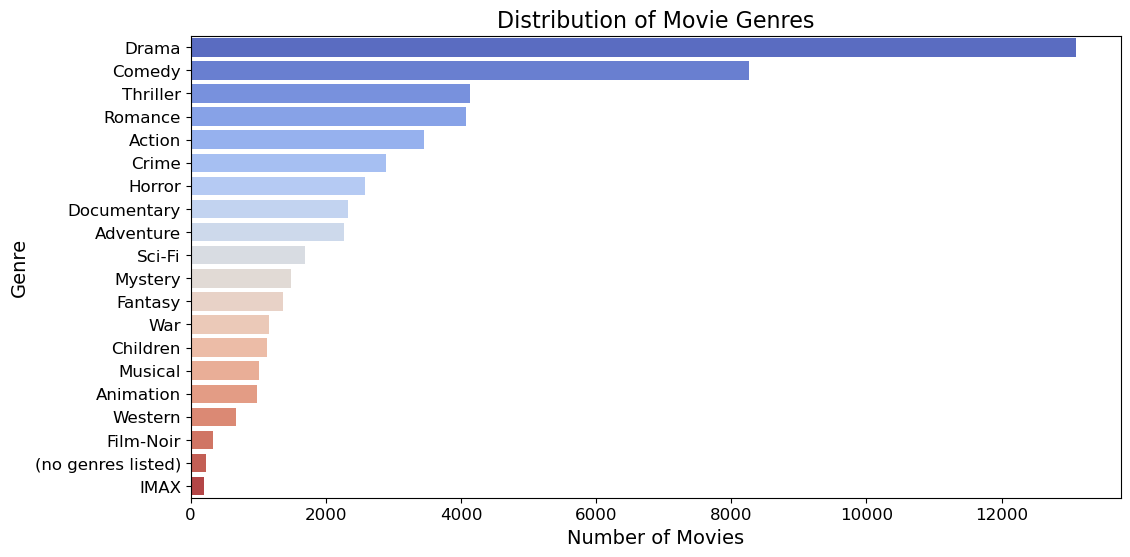

In [39]:
# Split genres and count
exploded_data = final_movie_data.explode('genres')

# Count the occurrences of each genre
genre_counts = exploded_data['genres'].value_counts().reset_index()
genre_counts.columns = ['genre', 'count']

# Plot the genre distribution
plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='genre', data=genre_counts, palette='coolwarm')
plt.title('Distribution of Movie Genres', fontsize=16)
plt.xlabel('Number of Movies', fontsize=14)
plt.ylabel('Genre', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


### movie ratings are right skewed with a mean of 6.17

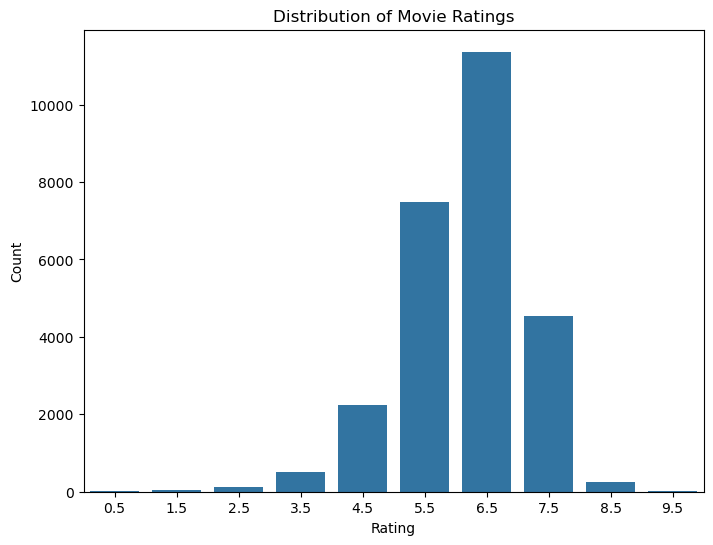

In [40]:
# Bin vote_average into intervals of 0.5
final_movie_data['vote_average_binned'] = pd.cut(final_movie_data['vote_average'], bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], labels=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5])

# Plot
plt.figure(figsize=(8, 6))
sns.countplot(x='vote_average_binned', data=final_movie_data, order=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5])
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

### Most movies have a generally "low" popularity score, but there are a few outliers with a score of 30 or higher.

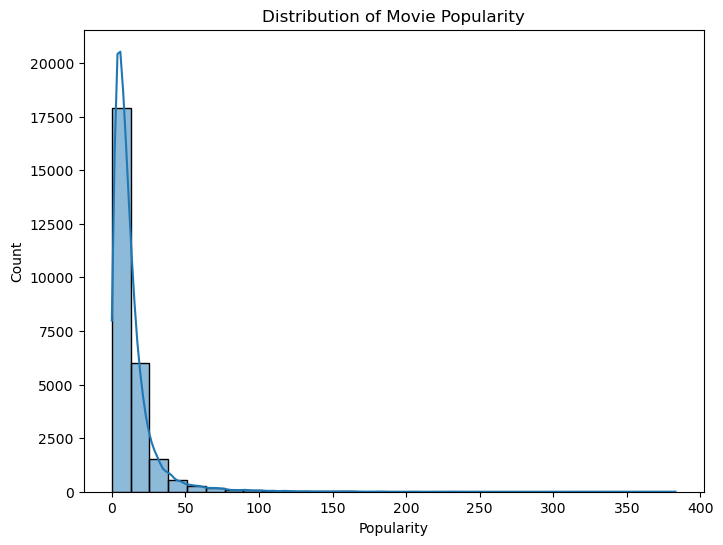

In [41]:
plt.figure(figsize=(8, 6))
sns.histplot(final_movie_data['popularity'], kde=True, bins=30)
plt.title('Distribution of Movie Popularity')
plt.xlabel('Popularity')
plt.ylabel('Count')
plt.show()


### The movie runtime is right skewed. Most movies are around 100 minutes long. 

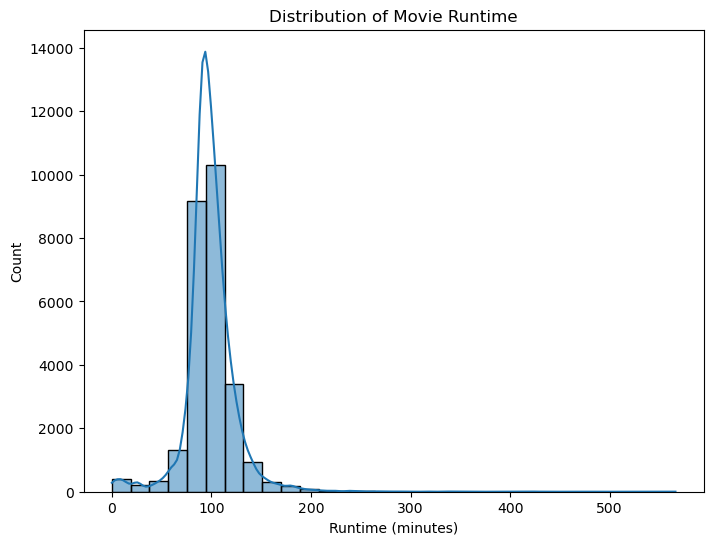

In [42]:
plt.figure(figsize=(8, 6))
sns.histplot(final_movie_data['runtime'], kde=True, bins=30)
plt.title('Distribution of Movie Runtime')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Count')
plt.show()


### average popularity by genre. IMAX are most popular, followed by Animation and children. 

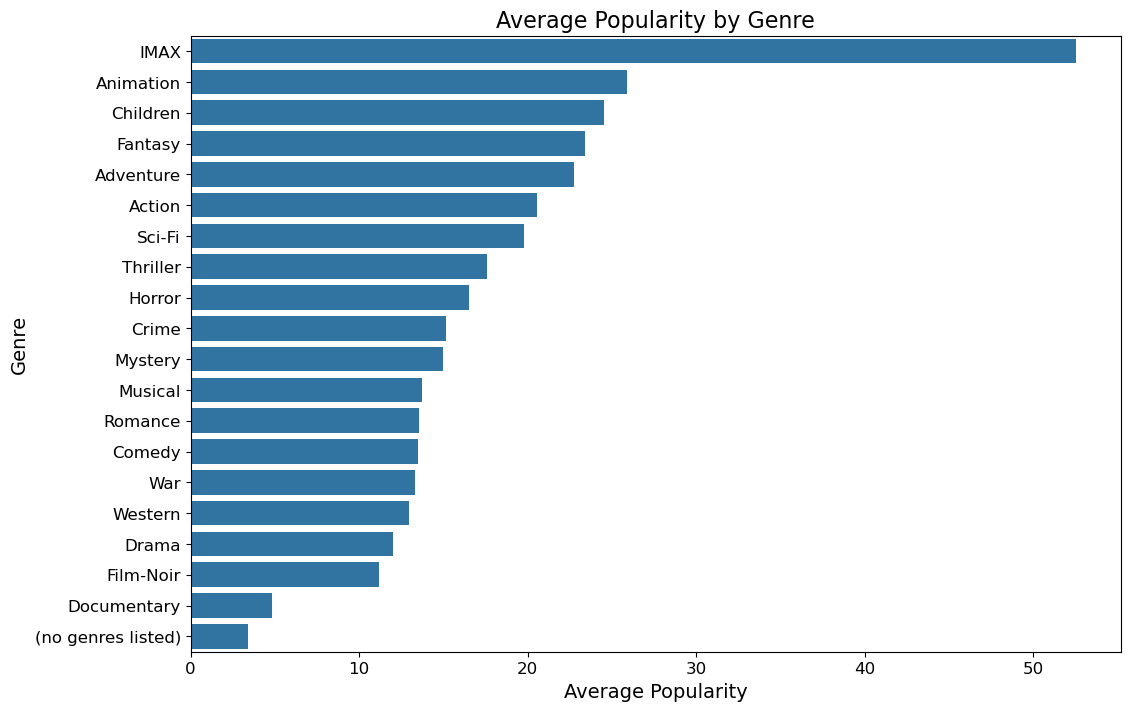

In [43]:
# Explode genres into separate rows
exploded_data = final_movie_data.explode('genres')

# Calculate the average popularity for each genre
genre_popularity = exploded_data.groupby('genres')['popularity'].mean().sort_values(ascending=False)

# Plot the top 20 genres by average popularity
plt.figure(figsize=(12, 8))  # Larger figure size
sns.barplot(x=genre_popularity.values[:20], y=genre_popularity.index[:20])  # Top 20 genres
plt.title('Average Popularity by Genre', fontsize=16)
plt.xlabel('Average Popularity', fontsize=14)
plt.ylabel('Genre', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### most popular genres

/var/folders/st/4hwsbql945n2qc_vr0l0b4xr0000gn/T/ipykernel_66112/1207561345.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='genre', data=genre_counts, palette='coolwarm')


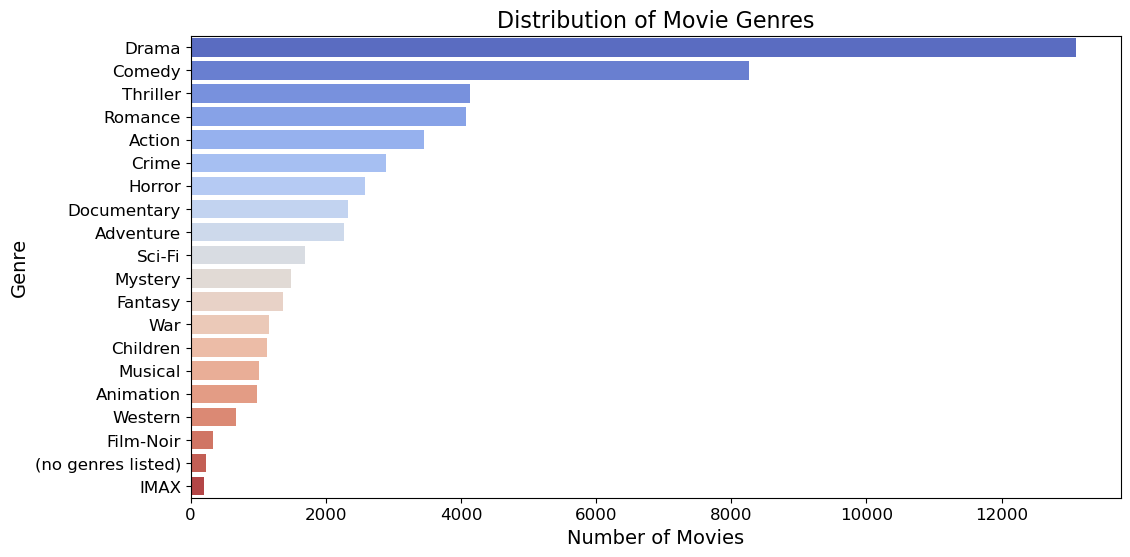

In [44]:

# Ensure 'genres' is split into lists, then explode into individual rows
exploded_data = final_movie_data.explode('genres')

# Count the occurrences of each genre
genre_counts = exploded_data['genres'].value_counts().reset_index()
genre_counts.columns = ['genre', 'count']

# Plot the genre distribution
plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='genre', data=genre_counts, palette='coolwarm')
plt.title('Distribution of Movie Genres', fontsize=16)
plt.xlabel('Number of Movies', fontsize=14)
plt.ylabel('Genre', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


### United States releases the most movies, followed by United Kingdom and France

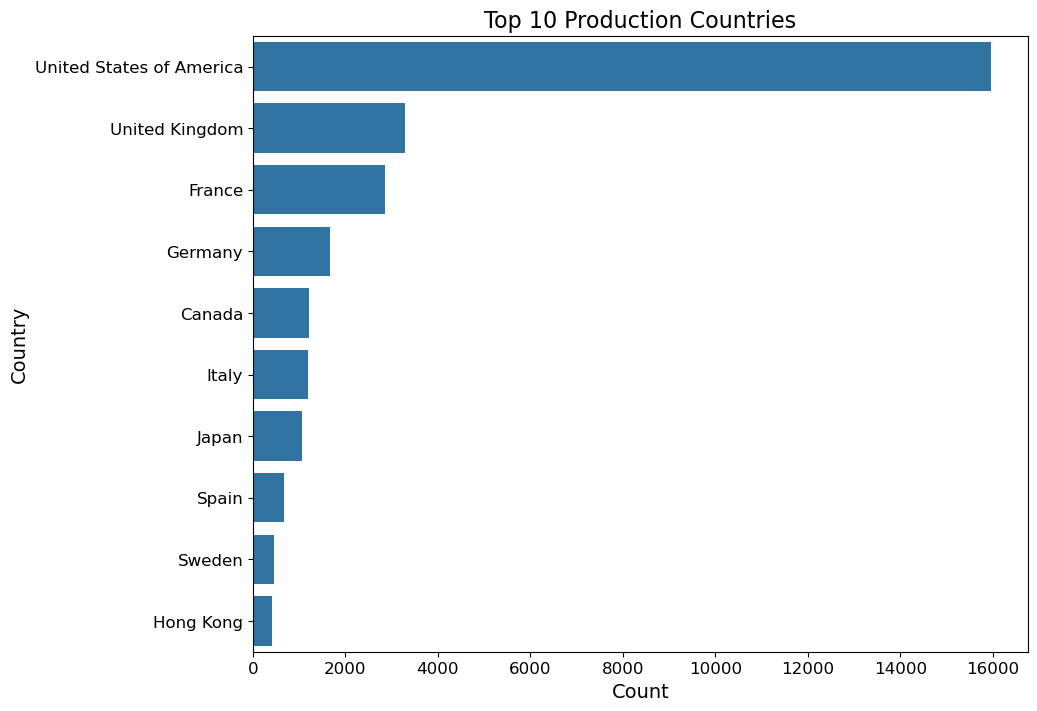

In [45]:
from collections import Counter
# Explode the production_countries column into separate rows
exploded_countries = final_movie_data.explode('production_countries')

# Count occurrences of each country
country_counts = Counter(exploded_countries['production_countries'].dropna())
top_countries = pd.DataFrame(country_counts.most_common(10), columns=['Country', 'Count'])

# Plot the top 10 production countries
plt.figure(figsize=(10, 8))  # Larger figure size for readability
sns.barplot(x='Count', y='Country', data=top_countries)
plt.title('Top 10 Production Countries', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Country', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### We see that countries like Malta, United Arab emirates and new zealand release very few movies, when they release new movies they seem to be very popular.

There are 157 unique production countries.
Number of movies for the top 10 countries by average popularity:
production_countries
Malta                           4
United Arab Emirates           21
New Zealand                    85
Libyan Arab Jamahiriya          2
Namibia                         3
Saudi Arabia                    2
Czech Republic                 72
Botswana                        3
Bulgaria                       39
United States of America    15964
Name: count, dtype: int64


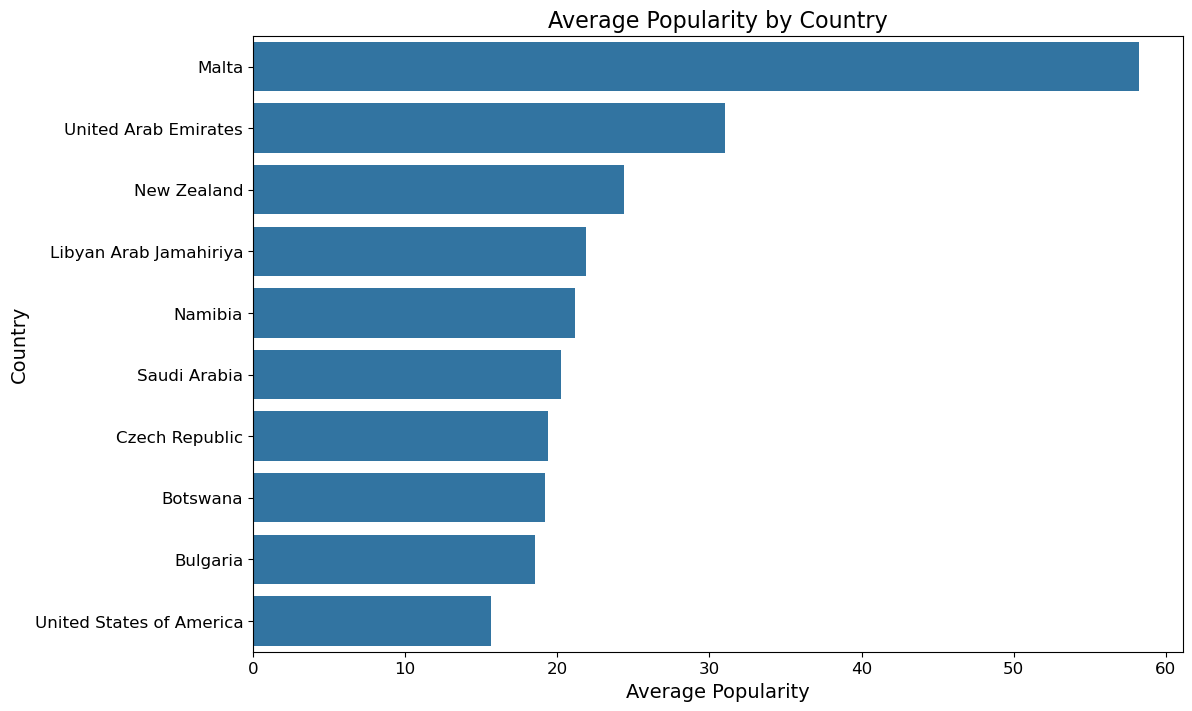

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming final_movie_data is already defined and loaded

# Explode the production_countries column into separate rows
exploded_countries = final_movie_data.explode('production_countries')

# Display the number of unique production countries
num_countries = exploded_countries['production_countries'].nunique()
print(f'There are {num_countries} unique production countries.')

# Calculate the average popularity for each country
country_popularity = exploded_countries.groupby('production_countries')['popularity'].mean().sort_values(ascending=False)

# Get the top 10 countries by average popularity
top_10_countries = country_popularity.index[:10]

# Calculate the number of movies for each of the top 10 countries
country_counts = exploded_countries['production_countries'].value_counts()
top_10_counts = country_counts[top_10_countries]

# Print the number of movies for each of the top 10 countries
print("Number of movies for the top 10 countries by average popularity:")
print(top_10_counts)

# Plot the top 10 countries by average popularity
plt.figure(figsize=(12, 8))
sns.barplot(x=country_popularity.values[:10], y=country_popularity.index[:10])
plt.title('Average Popularity by Country', fontsize=16)
plt.xlabel('Average Popularity', fontsize=14)
plt.ylabel('Country', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### The vote average among genres are quite evenly distributed with generally a median around 6, though we see that it is very difficult to get above 8. 

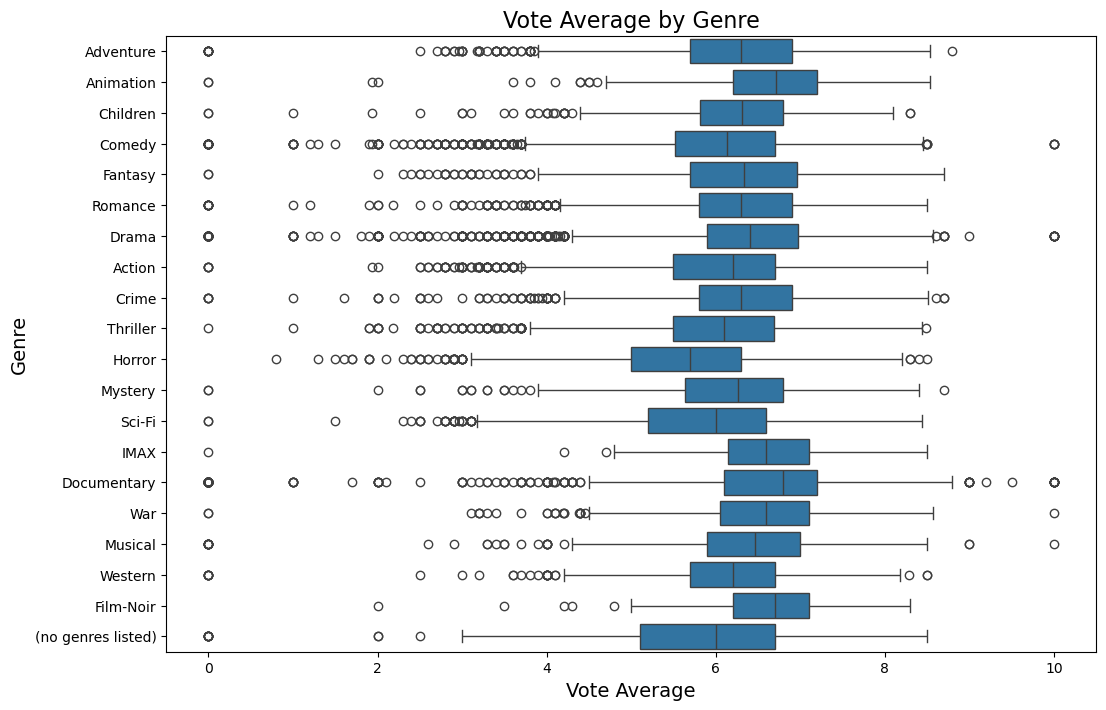

In [47]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='vote_average', y='genres', data=final_movie_data.explode('genres'))
plt.title('Vote Average by Genre', fontsize=16)
plt.xlabel('Vote Average', fontsize=14)
plt.ylabel('Genre', fontsize=14)
plt.show()

### We see that the release of new movies are exponential for every year upto covid-19

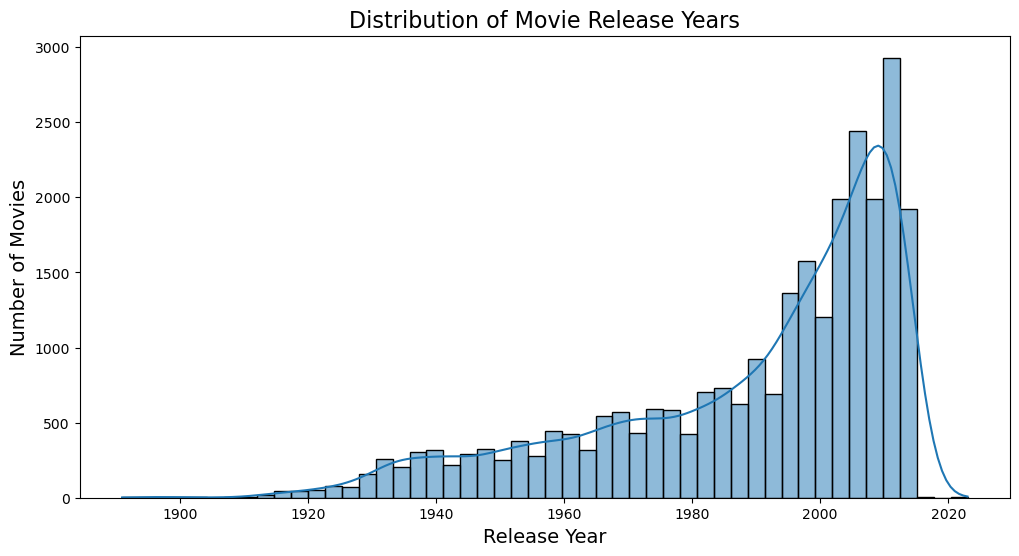

In [48]:
# Distribution of Movie Release Years
final_movie_data['release_year'] = pd.to_datetime(final_movie_data['release_date']).dt.year
plt.figure(figsize=(12, 6))
sns.histplot(final_movie_data['release_year'].dropna(), bins=50, kde=True)
plt.title('Distribution of Movie Release Years', fontsize=16)
plt.xlabel('Release Year', fontsize=14)
plt.ylabel('Number of Movies', fontsize=14)
plt.show()

A wordcloud of all the movie titles. Here we can also derive some dominate themes such sa "Love", "American", "Nigh" etc.



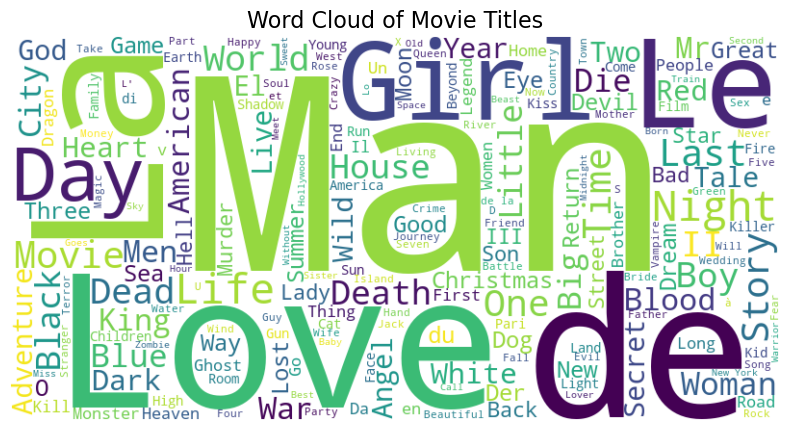

In [50]:
from wordcloud import WordCloud

import matplotlib.pyplot as plt

# Combine all movie titles into a single string
all_titles = ' '.join(final_movie_data['title'])

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_titles)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Movie Titles', fontsize=16)
plt.show()

### The imax movies are getting a lot of votes. Probably because these are cinemar releases.

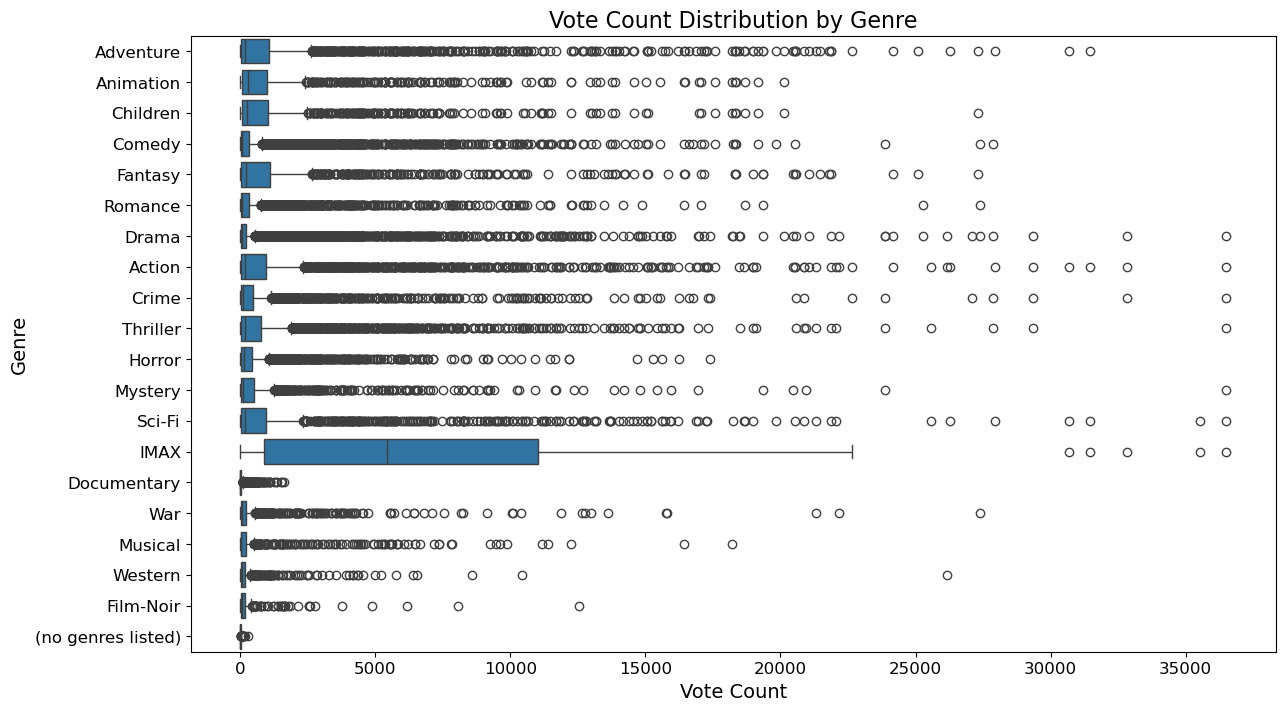

In [51]:
# Ensure 'genres' is split into lists, then explode into individual rows
exploded_data = final_movie_data.explode('genres')

# Plot the distribution of vote counts for each genre
plt.figure(figsize=(14, 8))
sns.boxplot(x='vote_count', y='genres', data=exploded_data)
plt.title('Vote Count Distribution by Genre', fontsize=16)
plt.xlabel('Vote Count', fontsize=14)
plt.ylabel('Genre', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### Movies with highest vote count, did also recieve very high rating.



/var/folders/st/4hwsbql945n2qc_vr0l0b4xr0000gn/T/ipykernel_66112/2157790168.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='vote_count', y='title', data=top_rated_movies, palette='viridis', orient='h')


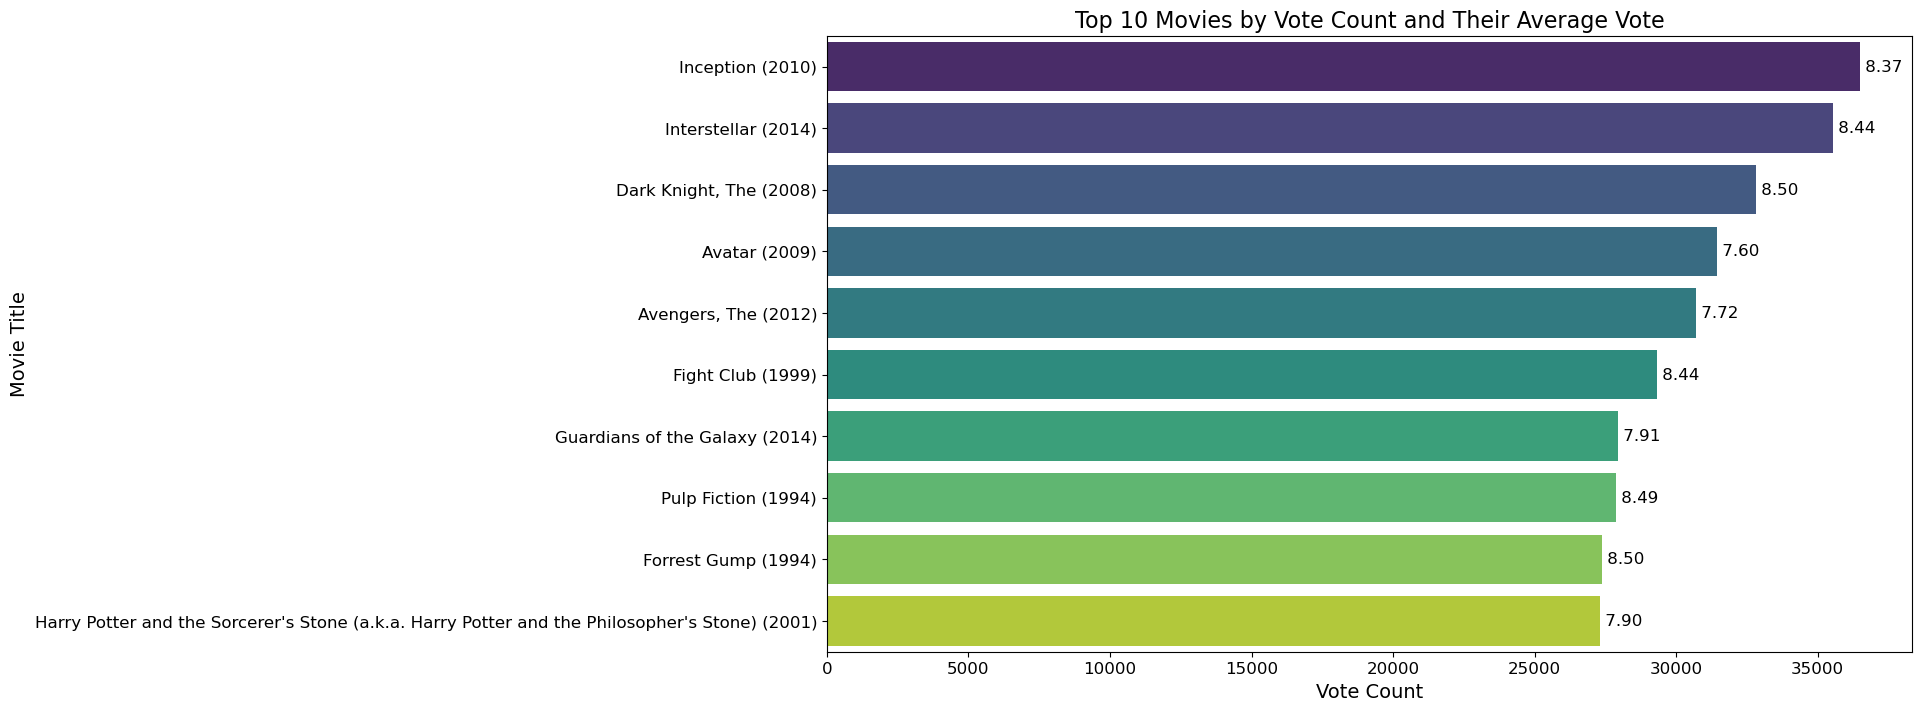

In [52]:
# Select the top 10 movies by vote count
top_rated_movies = final_movie_data.nlargest(10, 'vote_count')

# Plot the top-rated movies by vote count and their average vote
plt.figure(figsize=(14, 8))
sns.barplot(x='vote_count', y='title', data=top_rated_movies, palette='viridis', orient='h')
for index, value in enumerate(top_rated_movies['vote_average']):
    plt.text(top_rated_movies['vote_count'].iloc[index], index, f' {value:.2f}', va='center', ha='left', color='black', fontsize=12)
plt.title('Top 10 Movies by Vote Count and Their Average Vote', fontsize=16)
plt.xlabel('Vote Count', fontsize=14)
plt.ylabel('Movie Title', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### Some movies only have 1 very positive rating.

/var/folders/st/4hwsbql945n2qc_vr0l0b4xr0000gn/T/ipykernel_66112/2422166803.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='vote_average', y='title', data=top_10_vote_average, palette='viridis', orient='h')


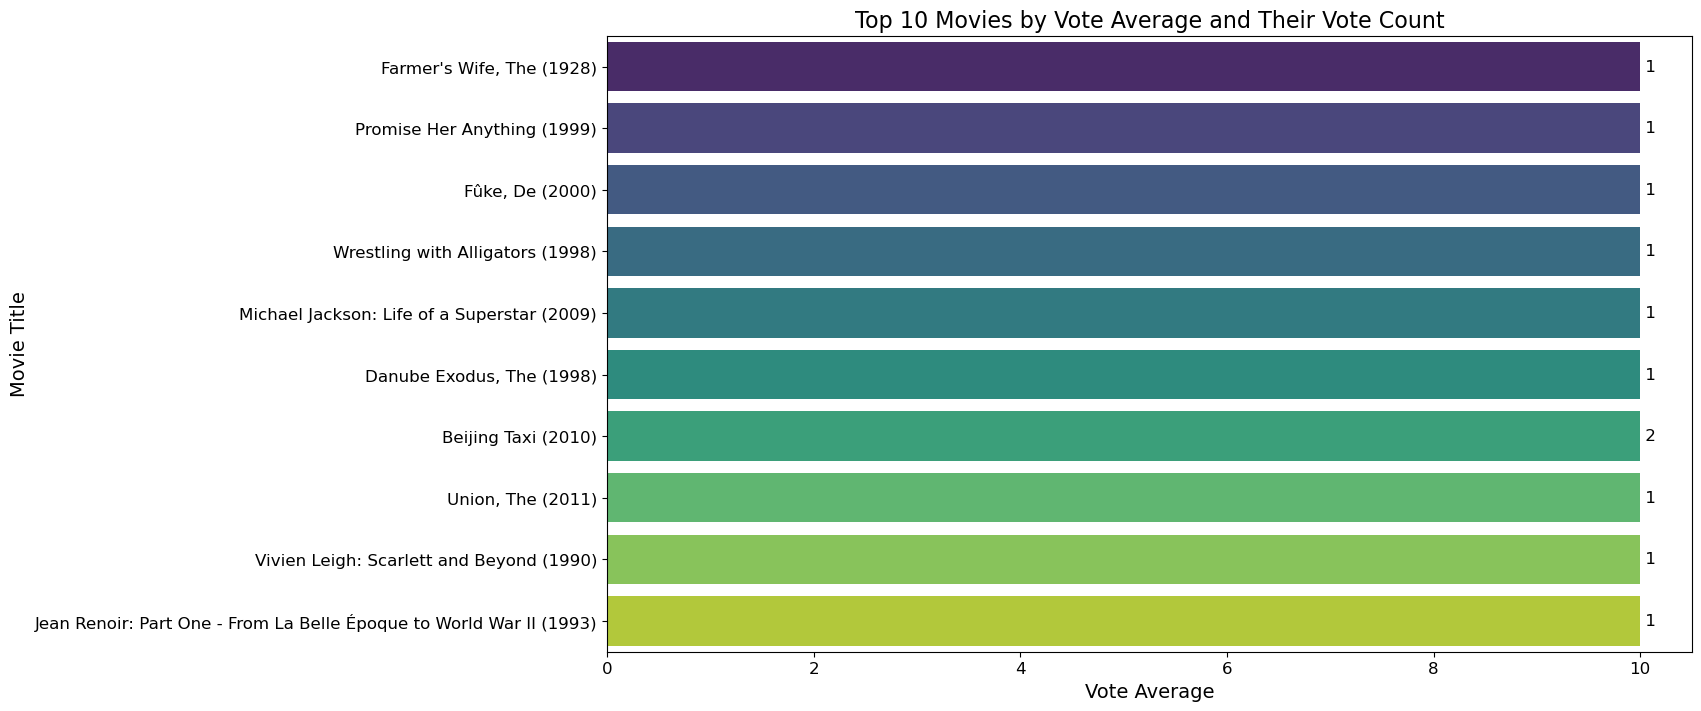

In [53]:
# Select the top 10 movies by vote average
top_10_vote_average = final_movie_data.nlargest(10, 'vote_average')

# Plot the top 10 movies by vote average and their vote count
plt.figure(figsize=(14, 8))
sns.barplot(x='vote_average', y='title', data=top_10_vote_average, palette='viridis', orient='h')
for index, value in enumerate(top_10_vote_average['vote_count']):
    plt.text(top_10_vote_average['vote_average'].iloc[index], index, f' {value}', va='center', ha='left', color='black', fontsize=12)
plt.title('Top 10 Movies by Vote Average and Their Vote Count', fontsize=16)
plt.xlabel('Vote Average', fontsize=14)
plt.ylabel('Movie Title', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### Generally, we see there is a upper limit of vote_average when you have many votes. It is very hard to get above 8 in rating.




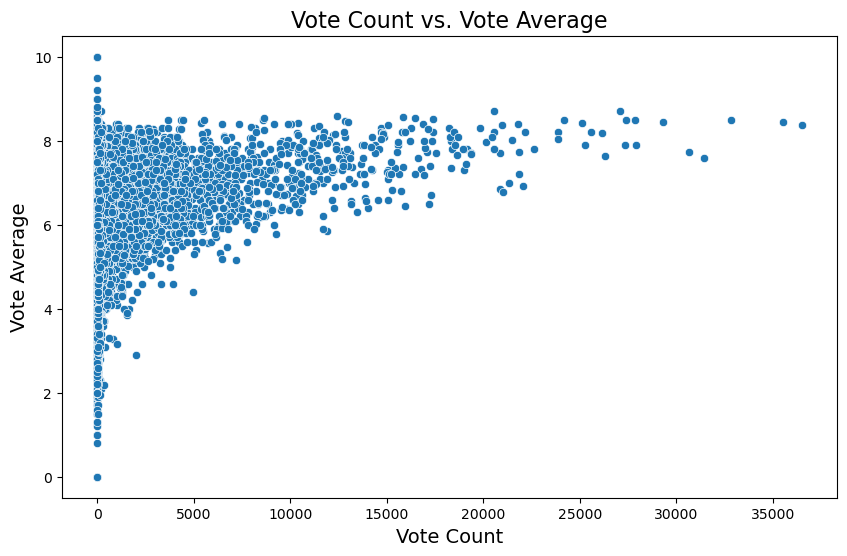

In [54]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='vote_count', y='vote_average', data=final_movie_data)
plt.title('Vote Count vs. Vote Average', fontsize=16)
plt.xlabel('Vote Count', fontsize=14)
plt.ylabel('Vote Average', fontsize=14)
plt.show()

### We see a tendency that the more votes a movie has, the more popular it is.

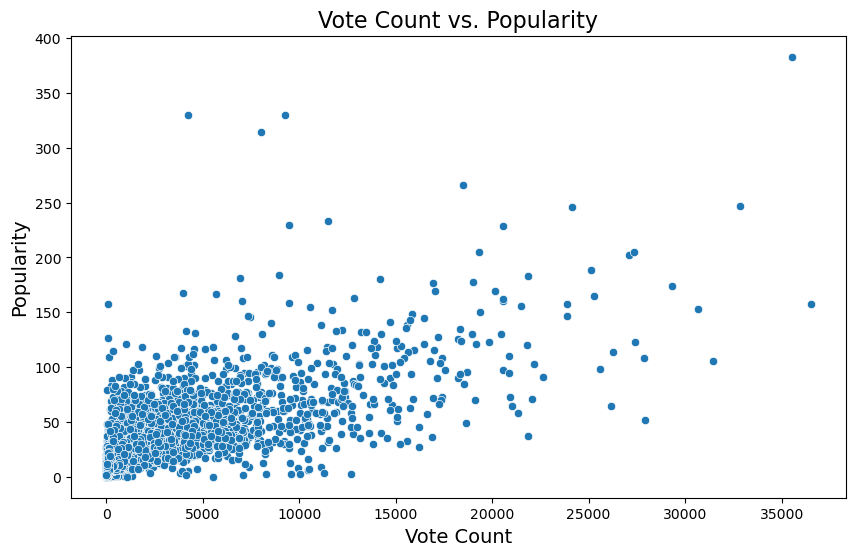

In [56]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='vote_count', y='popularity', data=final_movie_data)
plt.title('Vote Count vs. Popularity', fontsize=16)
plt.xlabel('Vote Count', fontsize=14)
plt.ylabel('Popularity', fontsize=14)
plt.show()